In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [51]:
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

from librep.datasets.motionsense import (
    RawMotionSense,
    RawMotionSenseIterator,
    MotionSenseDatasetGenerator,
    MotionSenseDataset,
)
from librep.utils.dataset import load_full_data

%matplotlib inline

In [3]:
dataset_dir = Path("../data/datasets/MotionSense/A_DeviceMotion_data")
motionsense_dataset = RawMotionSense(dataset_dir, download=False)
motionsense_dataset

MotionSense Dataset at: '../data/datasets/MotionSense/A_DeviceMotion_data'

In [4]:
act_names = [motionsense_dataset.activity_names[i] for i in range(6)]
act_names

['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

In [5]:
iterator = RawMotionSenseIterator(motionsense_dataset)
iterator

MotionSense Iterator: users=24, activities=6

In [6]:
motionsense_v1 = MotionSenseDatasetGenerator(iterator, time_window=300, window_overlap=0)
motionsense_v1

Dataset generator: time_window=300, overlap=0, labels=class

In [7]:
train, validation, test = motionsense_v1.create_datasets(
    train_size=0.7,
    validation_size=0.1,
    test_size=0.2,
    ensure_distinct_users_per_dataset=True,
    balance_samples=True,
    seed=0
)

Generating full df over MotionSense View: 360it [00:27, 13.03it/s]


# Time

In [8]:
train_dataset = MotionSenseDataset(train, sensors=["userAcceleration", "rotationRate"], label_columns="class")
validation_dataset = MotionSenseDataset(validation, sensors=["userAcceleration", "rotationRate"], label_columns="class")
test_dataset = MotionSenseDataset(test, sensors=["userAcceleration", "rotationRate"], label_columns="class")

In [9]:
train_x, train_y = load_full_data(train_dataset, return_X_y=True)
validation_x, validation_y = load_full_data(validation_dataset, return_X_y=True)
test_x, test_y = load_full_data(test_dataset, return_X_y=True)

In [10]:
train_val_x = np.concatenate([train_x, validation_x])
train_val_y = np.concatenate([train_y, validation_y])
train_val_x.shape, train_val_y.shape

((1914, 1800), (1914,))

In [11]:
model = RandomForestClassifier()
model.fit(train_val_x, train_val_y)

RandomForestClassifier()

In [12]:
test_x.shape, test_y.shape

((492, 1800), (492,))

In [13]:
y_pred = model.predict(test_x)

In [14]:
print(classification_report(test_y, y_pred, target_names=act_names))

              precision    recall  f1-score   support

         dws       0.69      0.80      0.74        82
         ups       0.87      0.74      0.80        82
         sit       0.95      0.68      0.79        82
         std       0.75      0.96      0.84        82
         wlk       0.70      0.60      0.64        82
         jog       0.89      1.00      0.94        82

    accuracy                           0.80       492
   macro avg       0.81      0.80      0.80       492
weighted avg       0.81      0.80      0.80       492



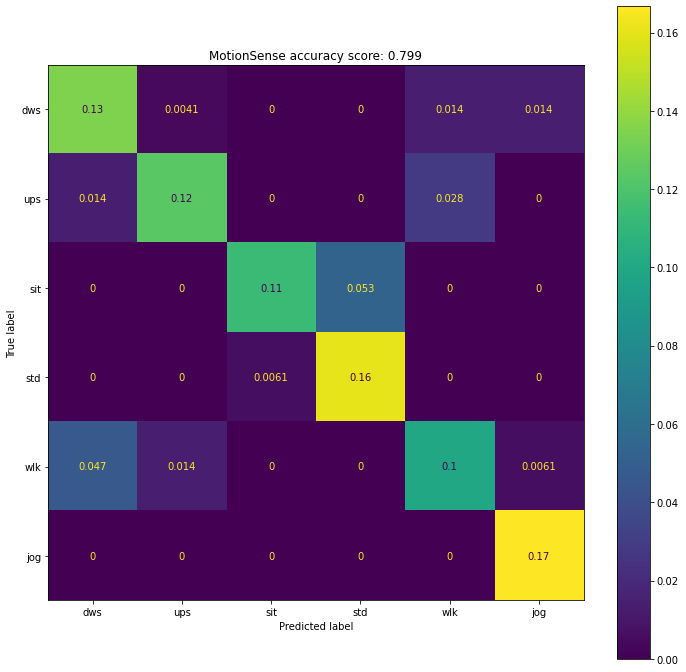

In [55]:
acc = accuracy_score(test_y, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"MotionSense accuracy score: {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(
    test_y,
    y_pred,
    display_labels=act_names,
    normalize="all",
    ax=ax,
    xticks_rotation=45
)
plt.show()

# FFT

In [15]:
from librep.utils.dataset import MultiFeatureDataset
from librep.transforms.fft import FFT
from functools import partial

features = [
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z",
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z"
]

fft_transform = FFT()

collate_fn = np.concatenate

fft_train_dataset = MultiFeatureDataset(
    train,
    features_columns=features,
    label_columns="class",
    per_sample_transform=fft_transform,
    collate_fn=collate_fn
)

fft_validation_dataset = MultiFeatureDataset(
    validation,
    features_columns=features,
    label_columns="class",
    per_sample_transform=fft_transform,
    collate_fn=collate_fn
)

fft_test_dataset = MultiFeatureDataset(
    test,
    features_columns=features,
    label_columns="class",
    per_sample_transform=fft_transform,
    collate_fn=collate_fn
)

In [16]:
fft_train_x, fft_train_y = load_full_data(fft_train_dataset, return_X_y=True)
fft_validation_x, fft_validation_y = load_full_data(fft_validation_dataset, return_X_y=True)
fft_test_x, fft_test_y = load_full_data(fft_test_dataset, return_X_y=True)

In [17]:
fft_train_val_x = np.concatenate([fft_train_x, fft_validation_x])
fft_train_val_y = np.concatenate([fft_train_y, fft_validation_y])
fft_train_val_x.shape, fft_train_val_y.shape

((1914, 1800), (1914,))

In [18]:
model = RandomForestClassifier()
model.fit(fft_train_val_x, fft_train_val_y)

RandomForestClassifier()

In [19]:
fft_test_x.shape, fft_test_y.shape

((492, 1800), (492,))

In [20]:
fft_y_pred = model.predict(fft_test_x)

In [21]:
print(classification_report(fft_test_y, fft_y_pred, target_names=act_names))

              precision    recall  f1-score   support

         dws       0.74      0.88      0.80        82
         ups       0.91      0.78      0.84        82
         sit       0.97      0.79      0.87        82
         std       0.82      0.98      0.89        82
         wlk       0.93      0.90      0.91        82
         jog       0.95      0.94      0.94        82

    accuracy                           0.88       492
   macro avg       0.89      0.88      0.88       492
weighted avg       0.89      0.88      0.88       492



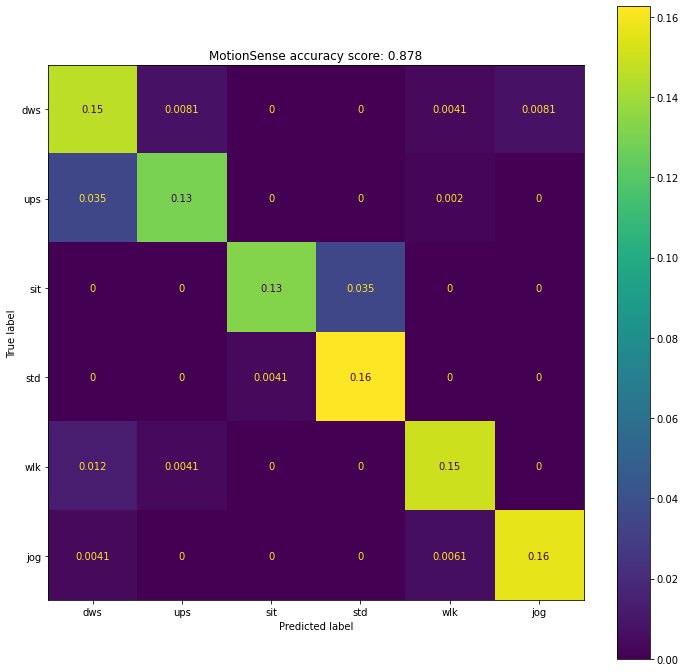

In [57]:
acc = accuracy_score(fft_test_y, fft_y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"MotionSense accuracy score: {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(
    fft_test_y,
    fft_y_pred,
    display_labels=act_names,
    normalize="all",
    ax=ax,
    xticks_rotation=45
)
plt.show()

# Fused

In [22]:
fused_train_val_x = np.concatenate([train_val_x, fft_train_val_x], axis=1)
fused_train_val_y = train_val_y
fused_train_val_x.shape, fused_train_val_y.shape

((1914, 3600), (1914,))

In [23]:
fused_test_x = np.concatenate([test_x, fft_test_x], axis=1)
fused_test_y = test_y
fused_test_x.shape, fused_test_y.shape

((492, 3600), (492,))

In [24]:
model = RandomForestClassifier()
model.fit(fused_train_val_x, fused_train_val_y)

RandomForestClassifier()

In [25]:
fused_y_pred = model.predict(fused_test_x)

In [26]:
print(classification_report(fused_test_y, fused_y_pred, target_names=act_names))

              precision    recall  f1-score   support

         dws       0.78      0.90      0.84        82
         ups       0.92      0.87      0.89        82
         sit       0.93      0.82      0.87        82
         std       0.84      0.94      0.89        82
         wlk       0.92      0.85      0.89        82
         jog       0.94      0.91      0.93        82

    accuracy                           0.88       492
   macro avg       0.89      0.88      0.88       492
weighted avg       0.89      0.88      0.88       492



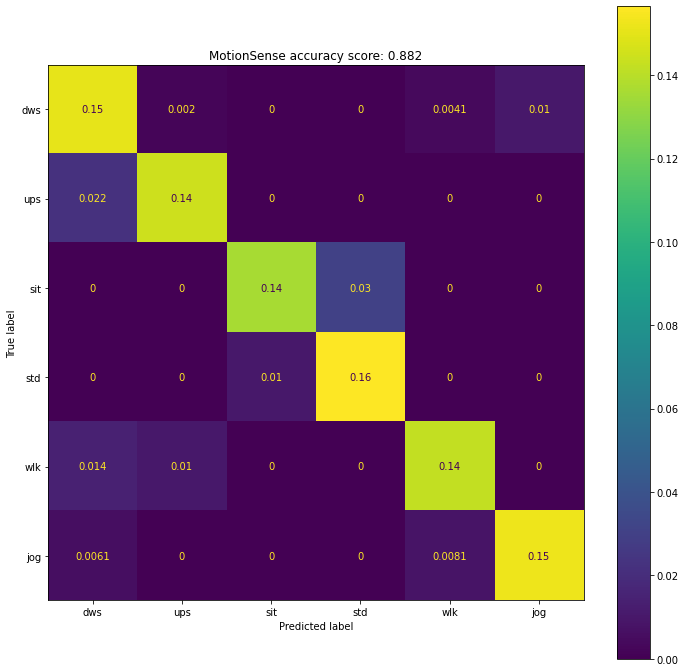

In [58]:
acc = accuracy_score(fused_test_y, fused_y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"MotionSense accuracy score: {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(
    fused_test_y,
    fused_y_pred,
    display_labels=act_names,
    normalize="all",
    ax=ax,
    xticks_rotation=45
)
plt.show()